# Reference
데이터: https://github.com/alexklibisz/isbi-2012

데이터 전처리 및 U-net 코드: https://github.com/HyunLee103/Pytorch_practice/blob/master/UNet_segmentation/UNet_train.ipynb


# 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 데이터 및 모듈 불러오기

In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms,datasets

(30, 512, 512)
(30, 512, 512)


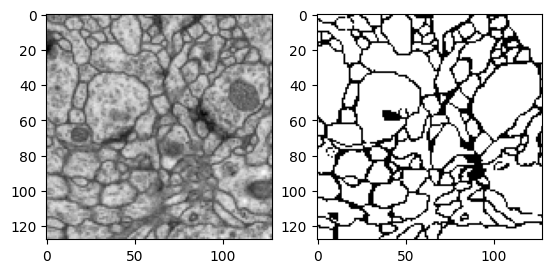

In [3]:
%matplotlib inline
from __future__ import print_function
from skimage.transform import resize #scikit-image
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import random
import hashlib

import sys; sys.path.append('../')
img_trn = tiff.imread('/content/gdrive/MyDrive/isbi-2012 dataset/train-volume.tif')
msk_trn = tiff.imread('/content/gdrive/MyDrive/isbi-2012 dataset/train-labels.tif')

print(img_trn.shape)
print(msk_trn.shape)

for img,msk in zip(img_trn, msk_trn):
    _img = resize(img, (128,128))
    _msk = resize(msk, (128,128)).round()
    fig,_ = plt.subplots(nrows=1, ncols=2)
    fig.axes[0].imshow(_img, cmap='gray')
    fig.axes[1].imshow(_msk, cmap='gray')
    plt.show()
    break

# 랜덤으로 이미지 회전 시키기

In [4]:
import numpy as np
from skimage.filters import gaussian
from skimage.transform import swirl, resize
from skimage.util import random_noise, crop


def random_transforms(items, nb_min=0, nb_max=5, rng=np.random):

    all_transforms = [
        lambda x: x,
        lambda x: np.fliplr(x),
        lambda x: np.flipud(x),
        lambda x: np.rot90(x, 1),
        lambda x: np.rot90(x, 2),
        lambda x: np.rot90(x, 3),
    ]

    n = rng.randint(nb_min, nb_max + 1)
    items_t = [item.copy() for item in items]
    for _ in range(n):
        idx = rng.randint(0, len(all_transforms))
        transform = all_transforms[idx]
        items_t = [transform(item) for item in items_t]
    return items_t

8


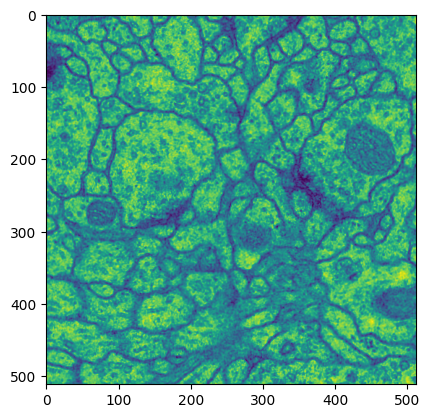

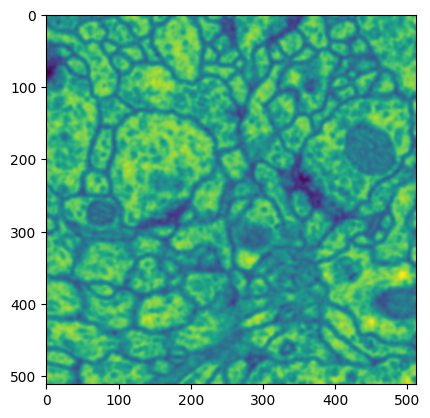

False


In [5]:
img = img_trn[0]
random.seed(865)

hashes = {}
for _ in range(10000):
    img_t = random_transforms([img]).pop()
    img_t = img_t.copy(order='C')
    hsh = hashlib.sha1(img_t).digest()
    hashes[hsh] = True

print(len(hashes.keys()))
8
from skimage.filters import gaussian
img = img_trn[0]
img_t = gaussian(img, sigma=2)
plt.imshow(img)
plt.show()

plt.imshow(img_t)
plt.show()

print(np.all(img_t == img))

# 데이터 전처리

tif 이미지 파일 load

In [6]:
dir_data = '/content/gdrive/MyDrive/isbi-2012 dataset'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

train,val, test 저장 dir 만들기

In [7]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train = os.path.join(dir_data,'train')
dir_save_val = os.path.join(dir_data,'val')
dir_save_test = os.path.join(dir_data,'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)
if not os.path.exists(dir_save_val):
    os.makedirs(dir_save_val)
if not os.path.exists(dir_save_test):
    os.makedirs(dir_save_test)

train과 validation으로 split하기

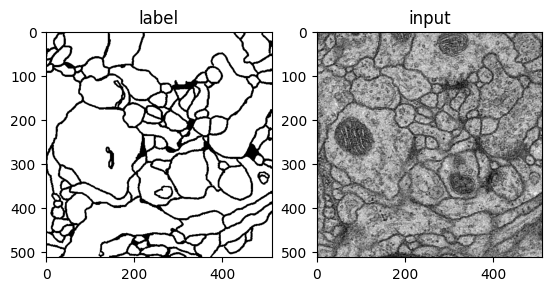

In [8]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

offset = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train,'label_%03d.npy'%i),label_) #numpy 파일로 저장
    np.save(os.path.join(dir_save_train,'input_%03d.npy'%i),input_)

offset += nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val,'label_%03d.npy'%i),label_)
    np.save(os.path.join(dir_save_val,'input_%03d.npy'%i),input_)


offset += nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset])
    img_input.seek(id_frame[i + offset])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test,'label_%03d.npy'%i),label_)
    np.save(os.path.join(dir_save_test,'input_%03d.npy'%i),input_)


plt.subplot(121)
plt.imshow(label_,cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_,cmap='gray')
plt.title('input')

plt.show()

In [9]:
print(label_.shape, input_.shape)

(512, 512) (512, 512)


# U-net 구조 구축


In [10]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)] # 2d cnn 과정
            layers += [nn.BatchNorm2d(num_features=out_channels)] # 배치 정규화 과정
            layers += [nn.ReLU()] # ReLU로 비선형 activation 만들기

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2) # 최대치 탐색

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True) # transposed convolution을 사용

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1) # 이어 붙이기
        dec4_2 = self.dec4_2(cat4) # 이어 붙인걸 convolution layer에 학습
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# Pytorch에 맞는 Dataloader 제작

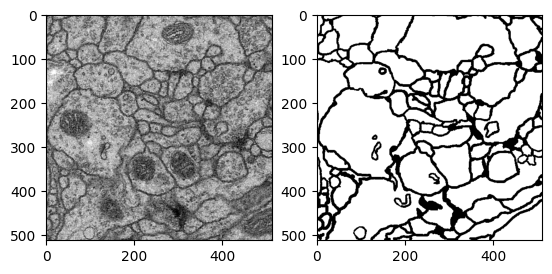

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')] # 문자열 검사해서 'label'이 있으면 True
        lst_input = [f for f in lst_data if f.startswith('input')] # 문자열 검사해서 'input'이 있으면 True

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        inputs = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # normalize
        label = label/255.0
        inputs = inputs/255.0
        label = label.astype(np.float32)
        inputs = inputs.astype(np.float32)

        # 인풋 데이터 차원이 2이면, 채널 축을 추가해줘야한다. 파이토치 인풋은 (batch, 채널, 행, 열)
        if label.ndim == 2:
            label = label[:,:,np.newaxis]
        if inputs.ndim == 2:
            inputs = inputs[:,:,np.newaxis]

        data = {'input':inputs, 'label':label}

        if self.transform:
            data = self.transform(data) # transform에 할당된 class 들이 호출되면서 __call__ 함수 실행

        return data


db = Dataset(data_dir='/content/gdrive/MyDrive/isbi-2012 dataset/train')

data = db.__getitem__(0)

inputs = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(inputs.squeeze(),cmap='gray')
plt.subplot(122)
plt.imshow(label.squeeze(),cmap='gray')

# Transform class 구현

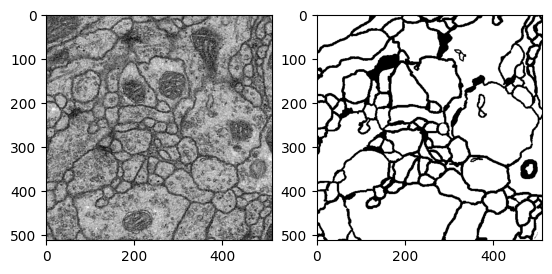

In [12]:
# numpy를 tensor화
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

# 정규화 과정
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

# 랜덤으로 flip 시도
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data


transform = transforms.Compose([Normalization(0.5,0.5),RandomFlip(),ToTensor()]) # compose로 위 세개의 class를 transform instance에 할당


db_train = Dataset(data_dir=os.path.join(dir_data,'train'),transform= transform)

data = db_train.__getitem__(5)

inputs = data['input']
label = data['label']

plt.subplot(121)
plt.imshow(inputs.squeeze(),cmap='gray') # squeeze()로 값이 1인 차원 날림(위에서 추가했던 축 차원(채널방향 1) 압축)
plt.subplot(122)
plt.imshow(label.squeeze(),cmap='gray')

In [13]:
inputs # nomalize

tensor([[[-0.1843,  0.1529,  0.0980,  ...,  0.0980,  0.0745,  0.2784],
         [ 0.2157,  0.0039, -0.1294,  ...,  0.2078,  0.4039,  0.4588],
         [ 0.1216,  0.0353,  0.0196,  ...,  0.3647,  0.4510,  0.6392],
         ...,
         [ 0.4431,  0.2941,  0.4588,  ..., -0.2235, -0.5843, -0.5451],
         [ 0.6078,  0.2941,  0.2157,  ..., -0.6235, -0.7961, -0.4980],
         [ 0.4510,  0.1451,  0.2549,  ..., -0.7020, -0.3961, -0.5059]]])

In [14]:
label # un nomarlize

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

# 하이퍼 파라미터 설정

In [39]:
## 하이퍼 파라미터 설정

lr = 1e-3
batch_size = 4
num_epoch = 100

data_dir = '/content/gdrive/MyDrive/isbi-2012 dataset'
ckpt_dir = '/content/gdrive/My Drive/Colab Notebooks/UNet/checkpoint'
log_dir = '/content/gdrive/My Drive/Colab Notebooks/UNet/log'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Prepare for train

In [37]:
# transform 적용해서 데이터 셋 불러오기
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=os.path.join(data_dir,'train'),transform=transform)

# 불러온 데이터셋, 배치 size줘서 DataLoader 해주기
loader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)

# val set도 동일하게 진행
dataset_val = Dataset(data_dir=os.path.join(data_dir,'val'),transform = transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size , shuffle=True)

# 네트워크 불러오기
net = UNet().to(device) # device : cpu or gpu

# loss 정의
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 정의
optim = torch.optim.Adam(net.parameters(), lr = lr )

# 기타 variables 설정
num_train = len(dataset_train)
num_val = len(dataset_val)

num_train_for_epoch = np.ceil(num_train/batch_size) # np.ceil : 소수점 반올림
num_val_for_epoch = np.ceil(num_val/batch_size)

# 기타 function 설정
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0,2,3,1) # device 위에 올라간 텐서를 detach 한 뒤 numpy로 변환
fn_denorm = lambda x, mean, std : (x * std) + mean
fn_classifier = lambda x :  1.0 * (x > 0.5)  # threshold 0.5 기준으로 indicator function으로 classifier 구현

# Tensorbord
writer_train = SummaryWriter(log_dir=os.path.join(log_dir,'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir,'val'))

# Training

In [38]:
# 네트워크 저장하기
# train을 마친 네트워크 저장
# net : 네트워크 파라미터, optim  두개를 dict 형태로 저장
def save(ckpt_dir,net,optim,epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net':net.state_dict(),'optim':optim.state_dict()},'%s/model_epoch%d.pth'%(ckpt_dir,epoch))

# 네트워크 불러오기
def load(ckpt_dir,net,optim):
    if not os.path.exists(ckpt_dir): # 저장된 네트워크가 없다면 인풋을 그대로 반환
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir) # ckpt_dir 아래 있는 모든 파일 리스트를 받아온다
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit,f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir,ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net,optim,epoch


# 네트워크 학습시키기
start_epoch = 0
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기

for epoch in range(start_epoch+1,num_epoch +1):
    net.train()
    loss_arr = []

    for batch, data in enumerate(loader_train,1): # 1은 뭐니 > index start point
        # forward
        label = data['label'].to(device)   # 데이터 device로 올리기
        inputs = data['input'].to(device)
        output = net(inputs)

        # backward
        optim.zero_grad()  # gradient 초기화
        loss = fn_loss(output, label)  # output과 label 사이의 loss 계산
        loss.backward() # gradient backpropagation
        optim.step() # backpropa 된 gradient를 이용해서 각 layer의 parameters update

        # save loss
        loss_arr += [loss.item()]

        # tensorbord에 결과값들 저정하기
        label = fn_tonumpy(label)
        inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
        output = fn_tonumpy(fn_classifier(output))

        writer_train.add_image('label', label, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', inputs, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_train_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)


    # validation
    with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
        net.eval() # 네트워크를 evaluation 용으로 선언
        loss_arr = []

        for batch, data in enumerate(loader_val,1):
            # forward
            label = data['label'].to(device)
            inputs = data['input'].to(device)
            output = net(inputs)

            # loss
            loss = fn_loss(output,label)
            loss_arr += [loss.item()]
            print('valid : epoch %04d / %04d | Batch %04d \ %04f | Loss %f'%(epoch,num_epoch,batch,num_val_for_epoch,np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            inputs = fn_tonumpy(fn_denorm(inputs, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_classifier(output))

            writer_val.add_image('label', label, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', inputs, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_val_for_epoch * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch이 끝날때 마다 네트워크 저장
        save(ckpt_dir=ckpt_dir, net = net, optim = optim, epoch = epoch)

writer_train.close()
writer_val.close()

valid : epoch 0021 / 0100 | Batch 0001 \ 1.000000 | Loss 0.198281
valid : epoch 0022 / 0100 | Batch 0001 \ 1.000000 | Loss 0.209271
valid : epoch 0023 / 0100 | Batch 0001 \ 1.000000 | Loss 0.200509
valid : epoch 0024 / 0100 | Batch 0001 \ 1.000000 | Loss 0.201316
valid : epoch 0025 / 0100 | Batch 0001 \ 1.000000 | Loss 0.212766
valid : epoch 0026 / 0100 | Batch 0001 \ 1.000000 | Loss 0.195053
valid : epoch 0027 / 0100 | Batch 0001 \ 1.000000 | Loss 0.179512
valid : epoch 0028 / 0100 | Batch 0001 \ 1.000000 | Loss 0.186726
valid : epoch 0029 / 0100 | Batch 0001 \ 1.000000 | Loss 0.194711
valid : epoch 0030 / 0100 | Batch 0001 \ 1.000000 | Loss 0.191417
valid : epoch 0031 / 0100 | Batch 0001 \ 1.000000 | Loss 0.193055
valid : epoch 0032 / 0100 | Batch 0001 \ 1.000000 | Loss 0.182875
valid : epoch 0033 / 0100 | Batch 0001 \ 1.000000 | Loss 0.178203
valid : epoch 0034 / 0100 | Batch 0001 \ 1.000000 | Loss 0.189844
valid : epoch 0035 / 0100 | Batch 0001 \ 1.000000 | Loss 0.190232
valid : ep

# Test Data를 학습된 U-net에 돌리기

In [43]:
net, optim, start_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim) # 저장된 네트워크 불러오기
dataset_test = Dataset(data_dir=os.path.join(data_dir,'train'),transform=transform)
loader_test = DataLoader(dataset_test, batch_size = batch_size, shuffle=True)

In [50]:
print(len(dataset_test))

24


torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512]) torch.Size([4, 1, 512, 512])


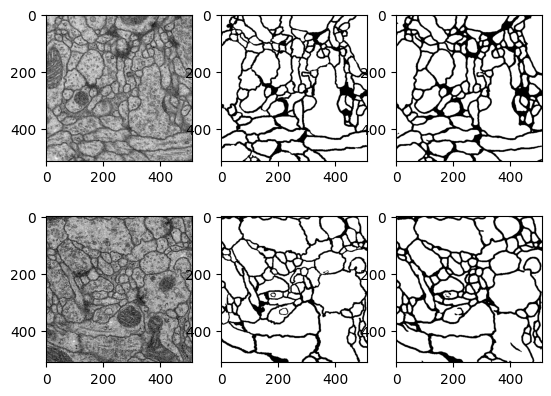

In [57]:
with torch.no_grad(): # validation 이기 때문에 backpropa 진행 x, 학습된 네트워크가 정답과 얼마나 가까운지 loss만 계산
  net.eval() # 네트워크를 evaluation 용으로 선언

  for batch, data in enumerate(loader_test,1):
    # forward
    label = data['label'].to(device)
    inputs = data['input'].to(device)
    output = net(inputs)
    print(label.shape, inputs.shape, output.shape)
    label = fn_tonumpy(label)
    inputs = fn_tonumpy(fn_denorm(inputs,0.5,0.5))
    output = fn_tonumpy(fn_classifier(output))

    plt.subplot(231)
    plt.imshow(inputs[0].squeeze(),cmap='gray') # squeeze()로 값이 1인 차원 날림(위에서 추가했던 축 차원(채널방향 1) 압축)
    plt.subplot(232)
    plt.imshow(label[0].squeeze(),cmap='gray')
    plt.subplot(233)
    plt.imshow(output[0].squeeze(),cmap='gray')

    plt.subplot(234)
    plt.imshow(inputs[2].squeeze(),cmap='gray') # squeeze()로 값이 1인 차원 날림(위에서 추가했던 축 차원(채널방향 1) 압축)
    plt.subplot(235)
    plt.imshow(label[2].squeeze(),cmap='gray')
    plt.subplot(236)
    plt.imshow(output[2].squeeze(),cmap='gray')
    break

In [58]:
print(output[0])

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [0.]]

 [[1.]
  [1.]
  [1.]
  ...
  [0.]
  [0.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]
